In [115]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calculate limb darkening coefficients

First... some imports!

In [165]:
from ExoCTK import core
from ExoCTK.ldc import ldcfit as lf
from ExoCTK.ldc import ldcplot as lp
import matplotlib.pyplot as plt

To calculate the limb darkening coefficients, we need a model grid. 

I'm going to use the Phoenix ACES models for this example but any grid can be loaded into a `core.ModelGrid()` object if the spectra are stored as FITS files.

We will pass a directory or directory+wildcard path to the initialize the model grid.

In [166]:
fits_files = '/user/jfilippazzo/Models/ACES/'
model_grid = core.ModelGrid(fits_files)
print(model_grid.data)

 Teff  logg ...                          filename                         
------ ---- ... ----------------------------------------------------------
2300.0  4.0 ... lte02300-4.00+0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2300.0  4.0 ... lte02300-4.00-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2300.0  4.0 ... lte02300-4.00-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2300.0  4.5 ... lte02300-4.50+0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2300.0  4.5 ... lte02300-4.50-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2300.0  4.5 ... lte02300-4.50-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2300.0  5.0 ... lte02300-5.00+0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2300.0  5.0 ... lte02300-5.00-0.0.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2300.0  5.0 ... lte02300-5.00-0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
2300.0  5.5 ... lte02300-5.50+0.5.PHOENIX-ACES-AGSS-COND-SPECINT-2011.fits
   ...  ... ...                                                        ...
2800.0  4.5 ... lte02800-

Now let's customize it to our desired effective temperature, surface gravity, metallicity, and wavelength ranges by running the `customize()` method on our grid.

In [167]:
model_grid.customize(Teff_rng=(2500,2600), logg_rng=(5,5.5), FeH_rng=(0,0), wave_rng=(1.1,1.9))

4/89 spectra in parameter range Teff: (2500, 2600) , logg: (5, 5.5) , FeH: (0, 0) , wavelength: (1.1, 1.9)


Now we can caluclate the limb darkening coefficients using the `ldcfit.ldc()` function.

We just need to specify the desired effective temperature, surface gravity, metallicity, and the function(s) to fit to the limb darkening profile (including 'uniform', 'linear', 'quadratic', 'square-root', 'logarithmic', 'exponential', and 'nonlinear').

We can do this with for a single model on the grid...

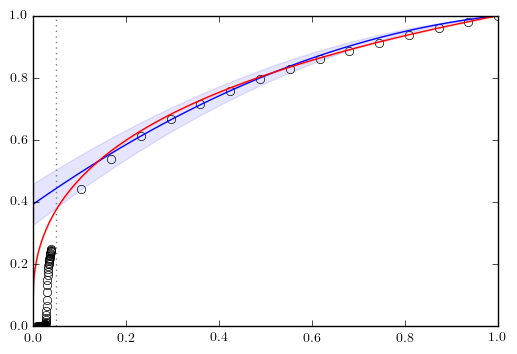

In [168]:
teff, logg, FeH = 2500, 5.0, 0.0
on_grid = lf.ldc(teff, logg, FeH, model_grid, ['quadratic','4-parameter'], plot=True)

...or a single model off the grid, where the spectral intensity model is directly interpolated before the limb darkening coefficients are calculated. This takes a minute...

Loading flux into table...
Interpolating grid point [2532/5.1/0.0]...
Run time in seconds:  97.60734391212463


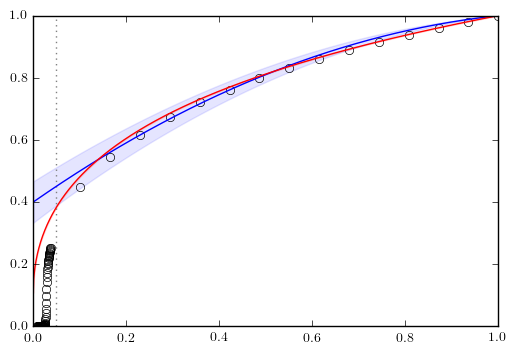

In [169]:
teff, logg, FeH = 2532, 5.1, 0.0
off_grid = lf.ldc(teff, logg, FeH, model_grid, ['quadratic','4-parameter'], plot=True)

## Using a Photometric Bandpass

Above we caluclated the limb darkening in a particular wavelength range set when we ran the `customize()` method on our `core.ModelGrid()` object. 

Additionally, we can calculate the limb darkening through a particular photometric bandpass.

First we have to create a `core.Filter()` object which we can then pass to the functions in the `ldcfit` module. Let's use 2MASS H-band for this example.

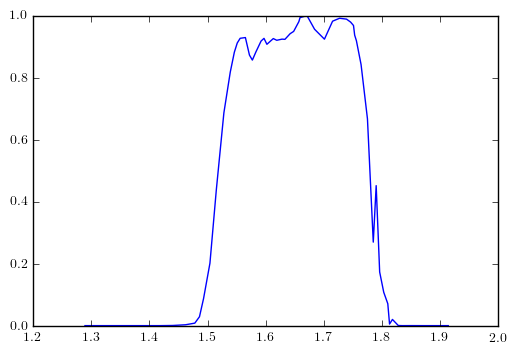

In [170]:
H_band = core.Filter('2MASS.H')
plt.plot(*H_band.rsr)

Now we can tell `ldcfit.ldc()` to apply the filter to the spectral intensity models before calculating the limb darkening coefficients using the `bandpass` argument. We'll compare the results of using the bandpass (blue line) to the plot above where we just used the wavelength window of 1.4-1.9 $\mu m$ (green line).

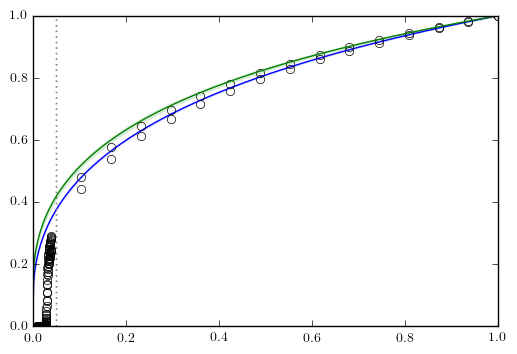

In [171]:
teff, logg, FeH = 2500, 5.0, 0.0
filt = lf.ldc(teff, logg, FeH, model_grid, '4-parameter', plot=True)
no_filt = lf.ldc(teff, logg, FeH, model_grid, '4-parameter', plot=plt.gcf(), bandpass=H_band, colors=['g'])

Enjoy!